# Using the Stats Package

The `Stats` package was written to make building simulations and collecting statistics about simulations using the Simpy framework simpler. 

`Stats` provides 3 main classes: 

1. Entity
2. Resource
3. Source


## Entity

An Entity is conceptually the "thing passing through your simulation".   

- An Entity requests resources, performs actions that take time, might reneg and jump out of long queues, etc...
- Each Entity has a set of attributes, stored internally as a dictionary. Examples of attributes might include:
    - Age
    - Food Preference
    - Likelihood to Reneg
    - etc...
- Entities track statistics about their unique journey through the simulation, including waiting time and processing time.

You must define a `process` method for your Entity class




## Resource

A Resource is something an Entity will interact with during a simulation.

- Often resources have a limited `capacity`. 
  - Capacity defines how many entities may be processed by a resource simulatenously before a queue starts to build up.
- Resources may access an entity's attributes to determine the service time for that entity.
- Resources track statistics about their queues size / utilization over time. 

You must define a `service_time` method for your Resource class.



## Source

A Source is used to start a simulation. It is responsible for the following:

- Defining a template for how entities are constructed and fed into a simulation.
- Defining the interarrival time for entities
  - This can be deterministic (e.g. every 5 minutes) or drawn from a distribution (e.g. poisson distribution).

You must define `interarrival_time_generator` and `build_entity` methods for your source class


## Using the Stats classes

To use the Stats classes in a simulation, you will need to create `sub-classes` of each the Entity, Resource and Source based on how you've modeled your scenario.

**Note:** It is recommended that you name your sub-classes in terms of the *domain* you are modeling. In the case of the call center:



## Modeling a Call Center

Consider the following scenario:

Say you are the operations manager at a call center. 
- Calls arrive every 1 minute, and you have a team of 2 employees ready to respond to calls. 
- Calls may be for small, medium, or large problems. Calls will fall in to these sizes with the following likelihoods:
  - small: 50%
  - medium: 35%
  - large: 15%
- Small problems take 1 minute, medium problems take 3, and large problems take 10 minutes to address.


How would you use the concepts of Entity, Resource, and Source to model the scenario above? See the following table for where each responsibility lies:

|                                 | Entity     | Resource | Source |
|---------------------------------|------------|----------|--------|
| Call                            | X          |          |        |
| How does call move through sim? | X          |          |        |
| CallCenter                      |            | X        |        |
| 5 Employees                     |            | X        |        |
| Service time for Sm,Md,Lg       |            | X        |        |
| Every 1 minute Call arrives     |            |          | X      |
| Assign Entity to Sm,Md,Lg       |            |          | X      |


Here is how we would name the subclasses of each Entity, Resource and Source:

- Entity Classname --> Call
- Resource Classname --> CallCenter
- Source Classname --> CallSource

And here are definitions of each subclass, with all required methods implemented:

In [46]:
import numpy as np
from Stats import Entity, Resource, Source
import simpy

## Here is the Entity Subclass
class Call(Entity):
    def process(self):
        request = self.request_resource(call_center)
        yield request
        
        self.start_service_at_resource(call_center)
        service_time = call_center.service_time(self)
        yield self.env.timeout(service_time)
        
        self.release_resource(call_center, request)

# Here is the Resource subclass
class CallCenter(Resource):
    def service_time(self, entity):
        problem_size = entity.attributes["problem_size"]
        if problem_size == "sm":
            return 1
        elif problem_size == "md":
            return 3
        else:  # size must be lg at this point
            return 10

# Here is the Source subclass
class CallSource(Source):
    def interarrival_time_generator(self):
        while True:
            yield 1 # every 1 minute, call should arrive to the simulation
    
    def build_entity(self):
        # choose problem_size for this entity based on distribution in scenario.
        problem_size = np.random.choice(["sm", "md", "lg"], p=[0.5, 0.35, 0.15])
        attributes = {
            "problem_size": problem_size
        }
        return Call(env, attributes)

In [57]:
# Now construct instances of Resource and Source.
np.random.seed(42) # set seed so random parts remain constant between simulations

env = simpy.Environment()
call_center = CallCenter(env, capacity=2) # configure 5 employee capacity
call_source = CallSource(env, number=20) # source will stop after 20 customers have been generated

env.process(call_source.start())
env.run()

Call 1 created_at: 1 attributes: {'problem_size': 'sm', 'priority': 1}
Call 1 requesting CallCenter: 1
Call 1 started processing at CallCenter : 1
Call 2 created_at: 2 attributes: {'problem_size': 'lg', 'priority': 1}
Call 2 requesting CallCenter: 2
Call 1 finished at CallCenter: 2
Call 2 started processing at CallCenter : 2
Call 1 disposed: 2
Call 3 created_at: 3 attributes: {'problem_size': 'md', 'priority': 1}
Call 3 requesting CallCenter: 3
Call 3 started processing at CallCenter : 3
Call 4 created_at: 4 attributes: {'problem_size': 'md', 'priority': 1}
Call 4 requesting CallCenter: 4
Call 5 created_at: 5 attributes: {'problem_size': 'sm', 'priority': 1}
Call 5 requesting CallCenter: 5
Call 3 finished at CallCenter: 6
Call 6 created_at: 6 attributes: {'problem_size': 'sm', 'priority': 1}
Call 6 requesting CallCenter: 6
Call 3 disposed: 6
Call 4 started processing at CallCenter : 6
Call 7 created_at: 7 attributes: {'problem_size': 'sm', 'priority': 1}
Call 7 requesting CallCenter: 7

In [48]:
# Now that the simulation has ended, we can use statistics methods on both source and resource to see what happened

system_time = call_source.get_total_times()
print("total_time:", call_source.get_total_times())
print("total waiting_time:", call_source.get_waiting_times()) 
print("total processing_time:", call_source.get_processing_times(), "\n")

print("waiting time for call_center resource", call_source.get_waiting_times(call_center))
print("processing time for call_center resource", call_source.get_processing_times(call_center), "\n")

print("call_center queue size over time", call_center.queue_size_over_time())
print("call_cetner utilization over time", call_center.utilization_over_time())


total_time: [1, 3, 1, 1, 3, 3, 2, 4, 10, 5, 7, 7, 9, 8, 8, 9, 16, 8, 10, 10]
total waiting_time: [0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 4, 6, 6, 5, 7, 6, 6, 7, 7, 9]
total processing_time: [1, 3, 1, 1, 3, 3, 1, 3, 10, 3, 3, 1, 3, 3, 1, 3, 10, 1, 3, 1] 

waiting time for call_center resource [0, 0, 0, 0, 0, 0, 1, 1, 0, 2, 4, 6, 6, 5, 7, 6, 6, 7, 7, 9]
processing time for call_center resource [1, 3, 1, 1, 3, 3, 1, 3, 10, 3, 3, 1, 3, 3, 1, 3, 10, 1, 3, 1] 

call_center queue size over time [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 2, 2, 3, 4, 4, 5, 6, 6, 5, 6, 6, 4, 3, 3, 2, 1, 1, 1, 0, 0, 0, 0]
call_cetner utilization over time [0, 0.5, 0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5]


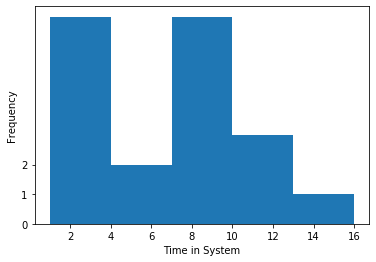

In [58]:
# we can use the return values from these statistics methods to create charts about our simulation's performance
import matplotlib.pyplot as plt

plt.hist(system_time,bins=5)
# you can customize the exact tick marks on an axis
plt.yticks(range(0,3))
plt.ylabel('Frequency');
plt.xlabel('Time in System');

Average number in queue: 3.875
Max in queue: 8


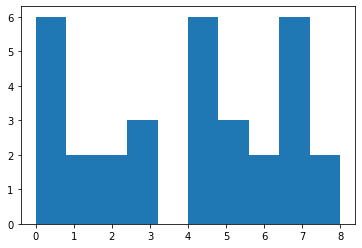

In [59]:
"""
Histogram of queue over time
"""
call_center_queue = call_center.queue_size_over_time()
plt.hist(call_center_queue)
print(f"Average number in queue: {np.mean(call_center_queue)}")
print(f"Max in queue: {np.max(call_center_queue)}")

Average utilization: 0.921875
Max utilization: 1.0


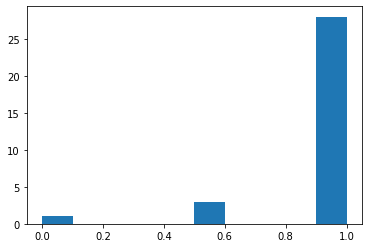

In [60]:
call_center_utilization = call_center.utilization_over_time()
plt.hist(call_center_utilization)
print(f"Average utilization: {np.mean(call_center_utilization)}")
print(f"Max utilization: {np.max(call_center_utilization)}")

# API Documentation for Stats Classes

## Entity

#### Methods that You Must Define:

`process(self)` - The steps for how your entity will pass through the simulation
- In the process method you will specify the order in which resources are interacted with by each entity in your system.

#### Constructing an Entity: 
`Constructor(env, attributes)` - constructor for entity class
- @param env: a simpy env
- @param attributes (optional): dictionary 

#### Static Variables

`priority`: integer (optional) - the priority assigned to all entities of this type.
- NOTE: priority is honored by resources when determining who to choose next in a queue.
- A lower number priority means the entity will be chosen first. 
- If no priority is specified, entities will have a default priority of 1

#### Predefined Methods: 

`request_resource(resource, priority_override)` - initiates a resource request
- @param resource: a stats resource
- @param priority_override (optional): keword arg - an integer to define the prioirty of the requesting entity in the resource queue  
- @returns: a simpy resource request (to be yielded)

`start_service_at_resource(resource)` - begins service at the given resource
- @param resource: a stats resource
- @returns: void

`release_resource(resource, request)` - completes service at the given resource
- @param resource: a stats resource
- @param request: a simpy resource request
- @returns: void

#### Statistics Methods

`get_waiting_time_for_resource(resource)` - returns the waiting time for the entity at the specified resource
- @param resource: a stats resource
- @returns: Int

`get_total_waiting_time()` - returns total waiting time for the entity during simulation
- @returns: Int

`get_processing_time_for_resource(resource)` - returns processing time for the entity at the specified resource
- @param resource: a stats resource
- @returns: Int

`get_total_processing_time()` - returns total processing time for the entity during simulation
- @returns: Int



## Resource

#### Methods That You Must Define:

`service_time(self, entity)` - determine the service time for an entity as it passes through the system
- @param self: instance method 
- @param entity: the entity being serviced
- @returns: number (Int or Float)

#### Constructing a Resource:

`Constructor(env, capacity=Integer)` - constructor for a resource
- @param env: a simpy env
- @param capacity: keword arg - the capacity of the resource


#### Statistics Methods

`queue_size_over_time(sample_frequency=[0.01, 0.1, 1])` - determine the queue size during simulation
- @param sample_frequency (optional) (default=1): keword arg - a number in the list [0.01, 0.1, 1]  
- @returns: [Int]

`utilization_over_time(sample_frequency=[0.01, 0.1, 1])` - determine the utilization of the resource during simulation
- @param sample_frequency (optional) (default=1): keword arg - a number in the list [0.01, 0.1, 1] 
- @returns: [Int]

**NOTE about sample_frequency parameter**: we cannot check the resource queue / utilization at every possible time increment, that would be intractable for continuous time simulations. The sample frequency parameter dictates the resolution at which we should sample the history of events that occurred during simulation. The Int array that is returned will have the same resolution as the sample frequency (if you specify 0.01 sample frequency, you will get 100 samples per time increment). The default sample frequency is 1, which will work great for discrete time simulations and should work reasonably well for continuous.



## Source

#### Methods That You Must Define: 

`interarrival_time_generator(self)` - a generator function that yields the time at which the next entity will arrive to the simulation
- @yields: number (Int or Float)


`build_entity(self)` - a template for how entities are constructed during simulation
- @returns: Stats Entity

#### Statistics Methods

`get_total_times()` - returns the total system time for each generated entity 
- @returns: [Int]

`get_waiting_times(resource)` - returns either the total waiting time or waiting time at a particular resource for each entity.
- @param resource (optional): a stats resource
- @returns: [Int]

`get_processing_times(resource)` - returns either the total processing time or processing time at a particular resource for each entity.
- @param resource (optional): a stats resource
- @returns: [Int]

Note for the `get_*_times` functions, the resource parameter is optional. If it is provided, it will give you either waiting or processing times at the given resource for each entity that was generated. If it is omitted, you will get total waiting times / processing times across all resources for each entity.


# Advanced Topics

For another day:
- Building a multiple resource simulation?
- Reneging entities
- Entities with different priorities
- Multiple entity class definitions (perhaps one for each Small Medium or Large)
- Simulations that end after a given time.